##### To run this in colab, uncomment the first line.

In [1]:
#!pip install "torch==1.4" "torchvision==0.5.0"
!curl -s https://course.fast.ai/setup/colab | bash

from fastai.vision import *
from fastai.metrics import error_rate
from urllib.request import urlopen
import requests
import json

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [2]:
response = json.loads(requests.get("http://arnelism.com/realestate/labelled/files.json").text)
response_documents = json.loads(requests.get("https://raw.githubusercontent.com/perens/picture-labelling/main/src/resources/dokumendi_blanketid.json").text)

In [4]:
!mkdir train
!mkdir train/facade
!mkdir train/facade_90
!mkdir train/facade_180
!mkdir train/facade_270
!mkdir train/interior
!mkdir train/interior_90
!mkdir train/interior_180
!mkdir train/interior_270
!mkdir train/document
!mkdir train/document_90
!mkdir train/document_180
!mkdir train/document_270

mkdir: cannot create directory ‘train’: File exists


In [5]:
facades = [url for url in response if "facade" in url]
interiors = [url for url in response if "interior" in url]
documents = [url for url in response_documents]


f = open("facades.csv", "a")
for url in facades:
  f.write(url + "\n")
f.close()

f = open("interiors.csv", "a")
for url in interiors:
  f.write(url + "\n")
f.close()

f = open("documents.csv", "a")
for url in documents:
  f.write(url + "\n")
f.close()


# assume default is 0 degrees
download_images("facades.csv", 'train/facade', max_pics=1000)
download_images("interiors.csv", 'train/interior', max_pics=1000)
download_images("documents.csv", 'train/document', max_pics=1000)

In [33]:
main_classes = ["facade", "interior", "document"]
degrees = [90, 180, 270]

for degree in degrees:
    for c in main_classes:
        for i in os.listdir("train/" + c):
            if i.endswith(".jpg"):
                try:
                    img = open_image(os.path.join("train/" + c, i))
                    rotate_img = img.rotate(degree)
                    new_folder = "train/" + c + "_" + str(degree)
                    new_img_path = os.path.join(new_folder, i)
                    rotate_img.save(new_img_path)
                except PIL.UnidentifiedImageError:
                    # can happen while opening faulty images, ignore at first..
                    None

KeyboardInterrupt: 

In [71]:
classes = ["facade", "facade_90", "facade_180", "facade_270"
           , "interior", "interior_90", "interior_180", "interior_270"
           , "document", "document_90", "document_180", "document_270"]
path = "train"
for c in classes:
    print(c)
    verify_images(f"{path}/{c}", delete=True, max_size=1000)

facade


cannot identify image file <_io.BufferedReader name='train/facade/00000027.jpg'>
cannot identify image file <_io.BufferedReader name='train/facade/00000593.jpg'>
interior


document


In [72]:
path = "train"
data = ImageDataBunch.from_folder(
    path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4
    ).normalize(imagenet_stats)


In [73]:
data.classes

['document', 'facade', 'interior']

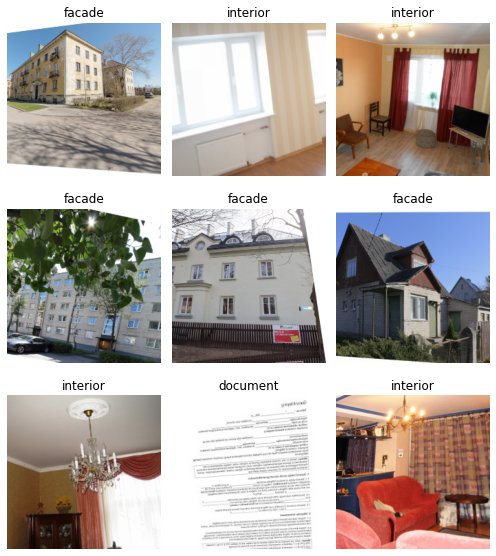

In [74]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(2) #change to 5 for more training
interp = ClassificationInterpretation.from_learner(learn)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jovyan/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.221267,0.012765,0.997494,11:20
1,0.097826,0.012190,0.997494,10:04


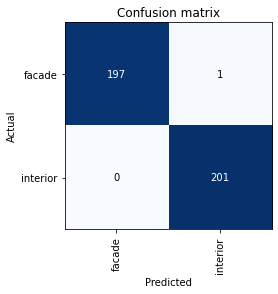

In [11]:
interp.plot_confusion_matrix()

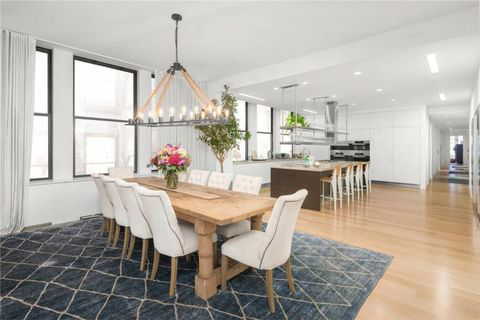

In [12]:
from urllib.request import urlopen
img = open_image(urlopen("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fhips.hearstapps.com%2Fhmg-prod.s3.amazonaws.com%2Fimages%2Fhbz-jennifer-lopez-penthouse-01-1507665932.jpg%3Fcrop%3D1xw%3A1xh%3Bcenter%2Ctop%26resize%3D480%3A*&f=1&nofb=1"))
img

In [13]:
pred_class,pred_idx,outputs = learn.predict(img)
print(outputs)
prediction = (data.classes[int(pred_class)], max(outputs)*100)
print(prediction)

tensor([1.8784e-06, 1.0000e+00])
('interior', tensor(99.9998))


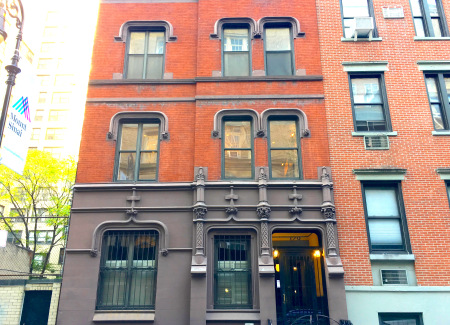

In [14]:
from urllib.request import urlopen
img = open_image(urlopen("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fephemeralnewyork.files.wordpress.com%2F2016%2F10%2Fapartmentfirstcloseup.jpg%3Fw%3D450%26h%3D326&f=1&nofb=1"))
img

In [61]:
pred_class,pred_idx,outputs = learn.predict(img)
print(outputs)
prediction = (data.classes[int(pred_class)], max(outputs.numpy()) * 100)
print(prediction)

tensor([9.9995e-01, 5.3120e-05])
('facade', 99.99468326568604)


###### model export, import

In [54]:
def export_model():
    learn.export("fastai.pkl")

def import_model():
    return load_learner('train/', 'fastai.pkl')

In [55]:
learn2 = import_model()

In [62]:
pred_class,pred_idx,outputs = learn2.predict(img)
print(outputs)
prediction = data.classes[int(pred_class)], max(outputs.numpy()) * 100
print(prediction)

tensor([9.9995e-01, 5.3120e-05])
('facade', 99.99468326568604)


###### document test

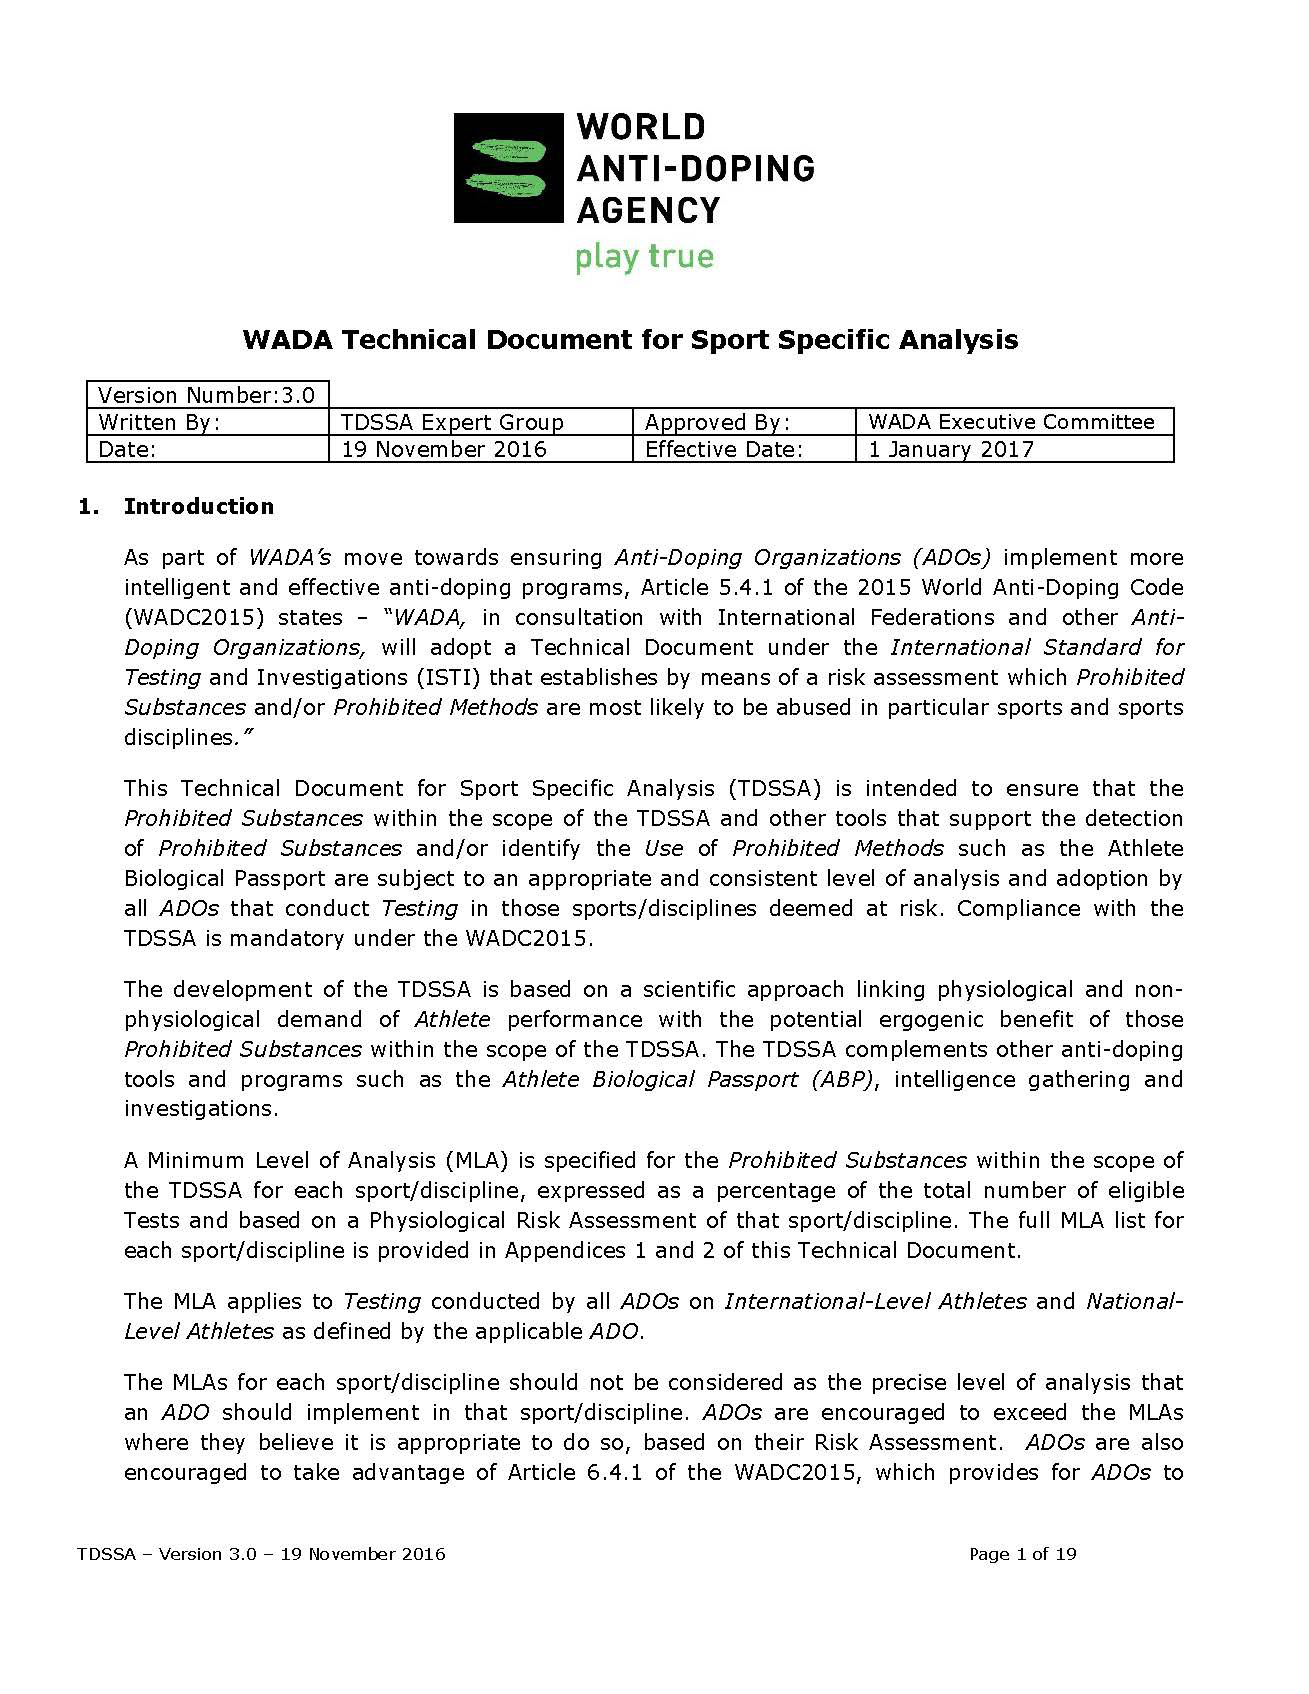

In [76]:
img = open_image(urlopen("https://www.wada-ama.org/sites/default/files/resources/thumbnails/tdssa_2017_eng_page_01.jpg"))
img

In [81]:
model = load_learner('train/', 'fastai_doc.pkl')
pred_class, pred_idx, outputs = model.predict(img)
prediction = data.classes[int(pred_class)], max(outputs.numpy()) * 100
print(prediction)

prediction = str(pred_class), max(outputs.numpy()) * 100
print(prediction)

('document', 100.0)
('document', 100.0)


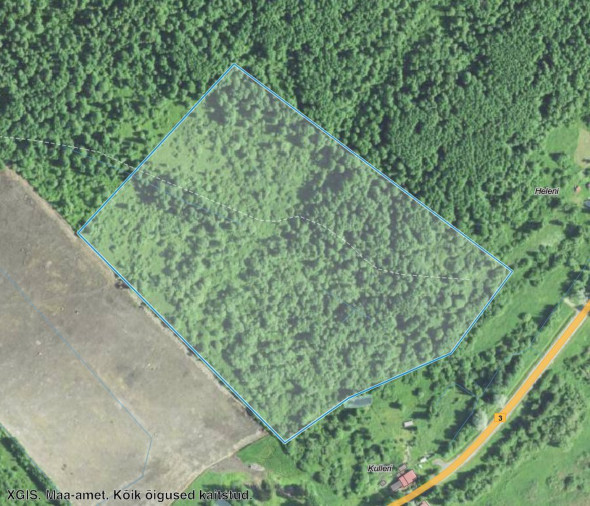

In [82]:
img = open_image(urlopen("https://cache.kv.ee/iv2/obj/1_35_66986835.jpg"))
img

In [83]:
model = load_learner('train/', 'fastai_doc.pkl')
pred_class, pred_idx, outputs = model.predict(img)
prediction = data.classes[int(pred_class)], max(outputs.numpy()) * 100
print(prediction)

prediction = str(pred_class), max(outputs.numpy()) * 100
print(prediction)

('facade', 91.15082621574402)
('facade', 91.15082621574402)
